In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Computing Probabilities
-----------------------

With the mathematical rules from probability theory one may compute the probability that a certain event 
happens.  For example, the probability that you get one black ball when drawing three balls from a hat with four 
black balls, six white balls, and three green balls. Unfortunately, theoretical calculations of 
probabilities may soon become hard or impossible if the problem is slightly changed. However, though it may
be complicated or impossible to compute such probabilities theoretically, in general there will always be
a simple  “numerical way” of computing probabilities that is generally applicable to problems with uncertainty. 

Principles of Monte Carlo Simulation
------------------------------------

Assume that we perform $N$ experiments (or in our case, $N$ computational simulations of experiments).  Suppose 
that some event takes place $M$ times in these $N$ experiments.  If we have created our simulation 
correctly (and there is nothing wrong with the way we generate random numbers), we could then estimate that 
the probability of the event occurring is $\frac{M}{N}$.  As we mentioned before, this estimate becomes 
more accurate as $N$ is increased, and the exact probability is assumed to be reached in the limit 
as $N \to \infty$

The technique of letting the computer perform lots of experiments based on drawing random samples is 
commonly called *Monte Carlo simulation*.  This is an empirical technique that approximates the correct 
answer, but we can make the approximation arbitrarily as close to the real answer as needed by increasing 
the number $N$ of simulations we perform.

Example: Throwing Dice
----------------------

What is the probability of getting a sum of 6 or more when rolling 4 dice?  Theoretically there are $6^4$ 
ways of rolling 4 dice.  We can only get less than a 6 total if we role all 1's [1 1 1 1] or if we 
roll a 2 and the rest are ones [2 1 1 1]  [1 2 1 1] [1 1 2 1] [1 1 1 2].  Any other combination will 
result in a sum of 6 or higher.  So the probability is very high, it is actually $\frac{6^4 - 5}{6^4} \approx 0.9961$.

What do we get if we simulate this experiment many times?

In [2]:
N = 100000 # num of experiments
M = 0    # num of successful events we see
for i in range(N):
    d = np.random.randint(1, 6+1, size=4) # simulate throwing 4 six sided dice
    s = np.sum(d)
    if s >= 6:
        M += 1
prob = float(M)/float(N)
print( 'Simulated probability was: %f' % prob ) 

Simulated probability was: 0.995820


As you should see, we get pretty good results with this number of simulations.

What is the probability of getting 2 or more sixes when rolling 4 dice.  Theoretically there are $6^4$ ways 
of rolling 4 dice.  We can get two or more sixes by for example rolling [6 1 6 3], or by rolling all 
sixes [6 6 6 6].  To find how many ways there are of getting 2, 3 or 4 sixes when rolling 4 die, we 
need to count up all the number of ways there are of getting such a combination.  The binomial distribution 
is used for calculating this analytically (don't worry if your not familiar with calculating a binomial distribution). 

In [3]:
from scipy.stats import binom
prb = binom.pmf(2, 4, 1.0/6.0) + binom.pmf(3, 4, 1.0/6.0) + binom.pmf(4, 4, 1.0/6.0)
print( prb ) 

0.131944444444


(In the previous calculation, we calculated the probability of getting 2 sixes, plus the number of ways of
getting 3 sixes, plus the number of ways of getting 4 sixes).

Lets confirm this empirically with a Monte Carlo simulation.  If you are not familiar with the theoretical tools
needed to calculate such a theory, then such a simulation may be more convincing in intiutively understanding
the probability of such events.  

The result you get with only 1000 simulated  trials might be a bit inaccurate.  Try the following with 
increasingly larger values of N to see if it seems to be getting the correct answer.

In [4]:
N = 1000 # num of experiments
M = 0     # num of successful events we see
for i in range(N):
    # roll 4 die, gives us a NumPy array of 4 dice rolls)
    d = np.random.randint(1, 6+1, size=4)
    
    # determine the number of sixes we rolled
    s = np.sum(d == 6)
    if s >= 2:
        M += 1
prob = float(M)/float(N)
print( 'Simulated probability was: %f' % prob ) 

Simulated probability was: 0.135000


Lets make the above a little more general.  Lets turn it into a function that simulates rolling any
number of dice (not just 4).  Also we will want to be able to specify the number of sixes equal to
or  greater we need to roll to call a trial a success.  Lets also add N (the number of experiments) 
as a default function parameter. Here is an example of this more general function:

In [5]:
def prob_getting_sixes(num_sixes, num_dice, N=1000):
    M = 0 # num of successful events we see
    for i in range(N):
        # roll num_dice dice
        d = np.random.randint(1, 6+1, size=num_dice)
        
        # determine the number of sixes we rolled
        s = np.sum(d == 6)
        if s >= num_sixes:
            M += 1
            
    prob = float(M) / float(N)
    return prob

Lets run a couple of quick tests.  We can rerun the original question (probability of getting 2 or more sixes with 
4 dice).  If we ask the probability of getting 5 sixes with 5 dice, there is only 1 way this can happen 
(rolling all sixes), thus the probability is $\frac{1}{6^5} \approx .000128$.  We can do the same for any 
q dice roll q sixes, so for 7 dice, the probability of getting 7 sixes is $\frac{1}{6^7} \approx 3.5\times 10^{-06}$.

In [6]:
np.set_printoptions(precision=12, suppress=True)
print( prob_getting_sixes(2, 4, N=10000) ) 
print( prob_getting_sixes(5, 5, N=100000) ) 
#print( prob_getting_sixes(7, 7, N=1000000) ) 

0.1308
7e-05


More on the Accuracy of Monte Carlo Simulation
----------------------------------------------

Lets return to our dice example of rolling 2 or more sixes with 4 dice.  We know from theory that the 
probability is $\approx 0.131944$ .   Lets see the results of increasing the number of simulations 
we perform on how accurately the simulation estimates the probability.  We will run simulations of 
size 10, 100, 500, 1000, 5000 and 10000.  We will run 100 simulations with each of those size N experiments,
computing the mean and standard deviation of the 100 runs of each.  Lets see what happens:

In [7]:
N_sizes = [10, 100, 500, 1000, 5000, 10000]
means = []
stdevs = []
num_repeats = 100

for Ni, N in enumerate(N_sizes):
    sim_probs = []
    print( "N (%d)" % N, ) 
    for sim in range(num_repeats):
        print( sim, ) 
        p = prob_getting_sixes(2, 4, N=N)
        sim_probs.append(p)
    print( "" ) 
    means.append(np.mean(sim_probs))
    stdevs.append(np.var(sim_probs))

('N (10)',)
(0,)
(1,)
(2,)
(3,)
(4,)
(5,)
(6,)
(7,)
(8,)
(9,)
(10,)
(11,)
(12,)
(13,)
(14,)
(15,)
(16,)
(17,)
(18,)
(19,)
(20,)
(21,)
(22,)
(23,)
(24,)
(25,)
(26,)
(27,)
(28,)
(29,)
(30,)
(31,)
(32,)
(33,)
(34,)
(35,)
(36,)
(37,)
(38,)
(39,)
(40,)
(41,)
(42,)
(43,)
(44,)
(45,)
(46,)
(47,)
(48,)
(49,)
(50,)
(51,)
(52,)
(53,)
(54,)
(55,)
(56,)
(57,)
(58,)
(59,)
(60,)
(61,)
(62,)
(63,)
(64,)
(65,)
(66,)
(67,)
(68,)
(69,)
(70,)
(71,)
(72,)
(73,)
(74,)
(75,)
(76,)
(77,)
(78,)
(79,)
(80,)
(81,)
(82,)
(83,)
(84,)
(85,)
(86,)
(87,)
(88,)
(89,)
(90,)
(91,)
(92,)
(93,)
(94,)
(95,)
(96,)
(97,)
(98,)
(99,)

('N (100)',)
(0,)
(1,)
(2,)
(3,)
(4,)
(5,)
(6,)
(7,)
(8,)
(9,)
(10,)
(11,)
(12,)
(13,)
(14,)
(15,)
(16,)
(17,)
(18,)
(19,)
(20,)
(21,)
(22,)
(23,)
(24,)
(25,)
(26,)
(27,)
(28,)
(29,)
(30,)
(31,)
(32,)
(33,)
(34,)
(35,)
(36,)
(37,)
(38,)
(39,)
(40,)
(41,)
(42,)
(43,)
(44,)
(45,)
(46,)
(47,)
(48,)
(49,)
(50,)
(51,)
(52,)
(53,)
(54,)
(55,)
(56,)
(57,)
(58,)
(59,)
(60,)
(61,)
(62,)
(63,)
(64,)
(65,

We'll plot the results, using the standard deviations as measures of the error, or in other words how much each N experiment
size varied.

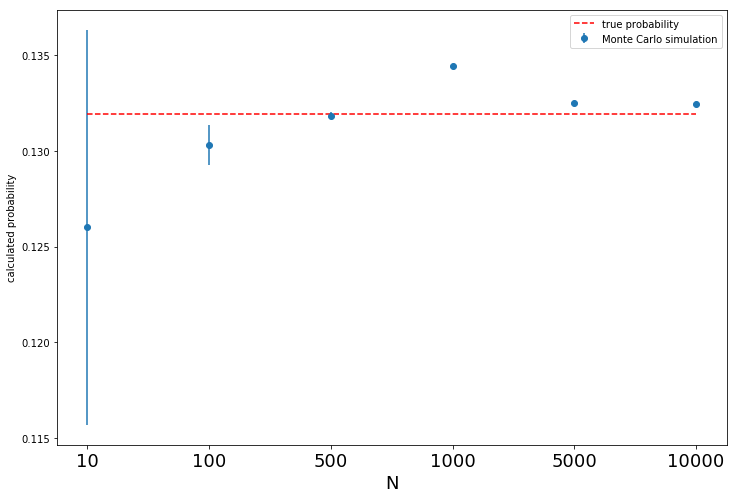

In [8]:
fig, ax = plt.subplots(figsize=(12,8))
ax.errorbar(range(1,7), means, fmt='o', yerr=stdevs, label='Monte Carlo simulation')
ax.plot([1,6], [0.131944, 0.131944], 'r--', label='true probability')
ax.set_xlim( (0.75, 6.25) )
ax.set_xticklabels([0] + N_sizes, fontsize=18)
ax.set_xlabel('N', fontsize=18)
ax.set_ylabel('calculated probability')
ax.legend()


Though the results may vary slightly when you run it, you should see that the lower simulation size N 
runs were both further away from the true probability (red dashed line), and had much greater 
variation in their performance.  The largest might not have happened to be the closest to 
the true probability, but  in general as N increases you will see this pattern where the 
simulated probability oscillates around the true probability, but in general continues 
to get closer and closer to true.  In  fact, if you reran this test, but started 
with $N = 10000$ as the smallest probability, and  tried several values up 
to $N = 1000000$, you would actually see pretty much the same graph, 
the only difference being that the range of y would be much smaller, but the variance 
of $N=10000$ would be much greater than that of $N=10000000$.

Calculation of $\pi$ using Monte Carlo Simulation
-------------------------------------------------

Lets try another example of a Monte Carlo simulation. Suppose that  you wanted to calculate
the value of $\pi$.  There are of course many ways, both analytical and  computational, 
that you could go about doing this.  Here we will develop a Monte Carlo simulation to 
estimate $\pi$ by using the following observation.  We all know that the formula for 
the area of a  circle is $A = \pi r^2$.  Therefore a circle with a radius of 1 unit 
would have an area equal to $\pi$ units.  Take that as a hint and take a moment to 
think about how you might go about simulating the area of a circle, so that we could 
estimate the value of $\pi$.

In essence the method we will suggest here is to simulate a virtual dart board game.  We will 
draw a circle, centered at the origin (0, 0) with a radius of 1.  The circle will be inside of
a square that exactly contains it.  The square, will thus have sides equal to 2 units, for a 
total area of 4. 

[-1.1, 1.1, -1.1, 1.1]

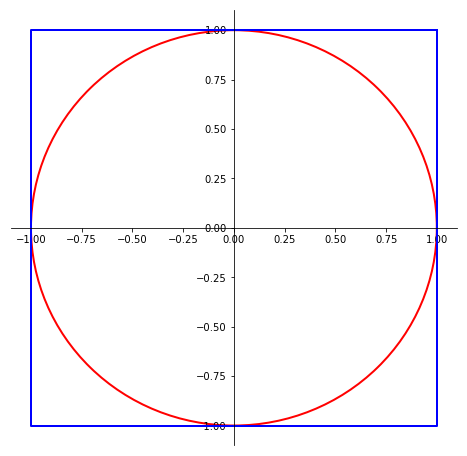

In [9]:
fig, ax = plt.subplots(figsize=(8,8))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('data',0)) # set position of x spine to x=0

ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data',0))   # set position of y spine to y=0

c = plt.Circle((0, 0), 1.0, edgecolor='r', fill=False, linewidth=2) # circle at origin with radius 1.0
ax.add_artist(c)
ax.plot([1, 1, -1, -1, 1], [1, -1, -1, 1, 1], color='b', linewidth=2) # square bounding circle
ax.axis([-1.1, 1.1, -1.1, 1.1])

Given the figure above and the hint about simulating throwing darts at a board, you should now be able to 
guess the algorithm we will create.  We basically need to simulate throwing many darts with a uniform 
probability of landing anywhere within the blue square (e.g. we need to generate x and y random numbers 
in the range of -1.0 to 1.0, and we already saw an example of doing just this in Part A of this 
module).  We need to have some method of determining, for each random throw of the dart, which random points 
are inside of the circle (which are successes), and which are outside.  This determination is easy, 
as all points that are a  distance of 1.0 or less from the origin are within the circle.  Then 
we will have the proportion M of points inside of the circle (these represent the successful trials
of our Monte Carlo simulation) to N the total points generated.  This 
proportion $\frac{M}{N}$ is the fraction of the area of the square that the circle occupies.  Since 
the square has an area of 4, then $4 \frac{M}{N}$ will be our answer of what is the area of the 
circle, and thus since the area of this circle with radius 1.0 is equal to $\pi$, we will also have 
estimated the value of $\pi$ using this Monte Carlo simulation.

The implementation of this once you understand the algorithm should be fairly simple and similar to 
previous examples.

('The area of the circle and value of pi is:', 3.1476)


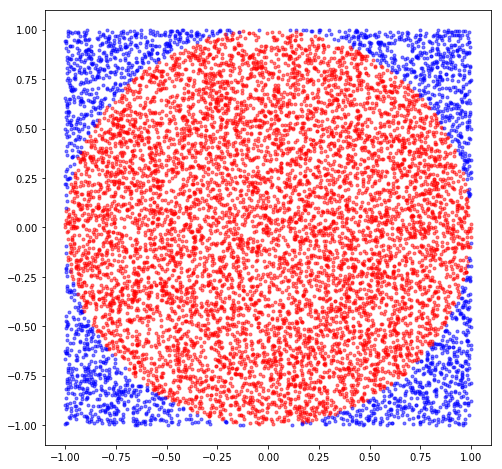

In [10]:
plt.figure(figsize=(8,8))

N = 10000 # number of experiments/darts to throw
M = 0 # count of number of darts thrown that land in the circle, the successful trials

for sim in range(N):
    x,y = np.random.uniform(-1.0, 1.000001, 2) # generate 2 points at random with uniform prob between -1.0 and 1.0
    if (x**2.0 + y**2.0)**0.5 <= 1.0: # if distance is 1.0 or less from origin, it is inside the circle
        M += 1
        plt.plot(x, y, 'r.', alpha=0.5)
    else:
        plt.plot(x, y, 'b.', alpha=0.5)
area = 4.0 * float(M) / float(N)
print( "The area of the circle and value of pi is:", area ) 

Population Growth Monte Carlo Simulation
----------------------------------------

The following example looks at a population growth computational model.  We will be looking at some differential
equation based population models in the next module of this course, so I thought this final example would be
relevant.  In addition, this example simulation has some similarity to Agent based modeling techniques, that
we may cover near the end of the course.

Suppose we create a collection of n individuals, called parents.  Each potential parent in our population has a single
attribute, `MALE` or `FEMALE`.  We will assume that the maximum number of couples that can be matched by the given
population will become mating pairs.  This will depend on the size of the `MALE` and `FEMALE` populations.  We can only 
have as many potential pairs as the minimum in either of these two subpopulations.  We will introduce a parameter
to the model that specifies the fertility rate.  Fertility rate is collected in most census information, and
represents the average number of children each woman in a population will have in their lifetime.  Another
parameter of the model will be the probability of having a male child.  The probability of a human birth
being male or female is naturally close to 0.5, but not exact (in fact we normally see 104 boys born for 100
girls, or a ratio of about 0.51).  This parameter is known as the sex ratio of our simulation.

Our task is to see how the parents array develop from one generation to the next .  We will
have a simple idea of a generation, the individuals in generation $t$ produce a new generation of offspring at 
$t+1$, who then become the population of potential parents for the next time step.  Because we are simulating
the evolution of the population generations over time, this simulation has some similarity to the sequence based
computational models we will discuss in the next lecture module.  And because we have a model of individuals
with the attribute `MALE` or `FEMALE`, this simulation has some of the characteristics of an agent based simulation.

Lets first give an example of drawing a random population of individuals, that produces a population with
a `MALE` to `FEMALE` ratio of sex_ratio:

In [11]:
MALE, FEMALE = 1,2 # constants, for code readability
n = int(1e6) # population size
sex_ratio = 0.5

population = np.zeros(n)
r = np.random.random(n)
population[r < sex_ratio] = MALE
population[r >= sex_ratio] = FEMALE
print( population.shape ) 

(1000000,)


Lets see the number of `MALE` individuals and `FEMALE` individuals that were created, and calculate the empirical
sex ratio that was generated using our given sex_ratio parameter.  While we are at it, we will make a small function
to count the sexes in a population, as we will need to do this several times.

In [12]:
def count_sexes(population):
    """Return a tuple of the number of MALEs and the number of FEMALEs in the given population
    """
    num_females = population[population==FEMALE].size
    num_males = population[population==MALE].size
    return (num_females, num_males)


In [13]:
num_females, num_males = count_sexes(population)
print( "famale individuals: %d   male individuals: %d" % (num_females, num_males) ) 
print( "generated sex ratio (num_males / population size): %f" % (float(num_males) / population.size) ) 

famale individuals: 500177   male individuals: 499823
generated sex ratio (num_males / population size): 0.499823


While we are at it, we are going to need that bit of code previously for creating a population of a given size with
individuals randomly distributed according to a given sex ratio several times:

In [14]:
def create_population(n, sex_ratio):
    """Create a population of size n, distributed with males/females in a ratio according to 
    sex_ratio.
    """
    new_pop = np.zeros(n)
    r = np.random.random(n)
    new_pop[r < sex_ratio] = MALE
    new_pop[r >= sex_ratio] = FEMALE
    return new_pop


Given a population, we want to simulate creating a next generation of children in a new population.  We will need
to look at the current generation of parents, count up the number of males and females, and from this determine
the number of potential couples.  As we mentioned, the minimum of these two subpopulations represents the maximum
number of potential couples that could form in a generation.  

Given the number of potential couples, we will then have the couples produce children for the next generation.  Here
we will use the fertility rate we mentioned.  We will use a gaussian distribution around the mean fertility
rate when generating childrine.  So fertility rate will be defined as two numbers.  First of all, the
mean fertility rate will be the average number of children each couple produces in the next generation.  We will
also give a fertility rate standard deviation (or sigma) in order to add some randomness into the number of
children produced, and be able to control the deviation.

Lets create a function that produces a child population generation from a given parent population as we just
described.

In [15]:
def produce_children(parents, fertility_rate, sex_ratio):
    """Given a generation of parents, produce the next generation of children.  We
    determine the number of eligible couples in this generation as the min(num_males, num_females).
    Each of these couples has fertility_rate children created in the next generation of children.
    The distribution of the sex of the children is randomly generated according to the sex_ratio
    """
    # determine the number of males/females and therfore the number of breeding couples in population
    num_males, num_females = count_sexes(parents)
    num_couples = min(num_males, num_females)
    
    # create fertility_rate children per couple
    fertility_rate_mean, fertility_rate_std = fertility_rate
    num_children = int(num_couples * np.random.normal(fertility_rate_mean, fertility_rate_std))
    if num_children < 1: # avoid divide by zero because of population collapse scenarios
        num_children = 1 
    children = create_population(num_children, sex_ratio)
    
    return children
    

In [16]:
# mean and standard deviation of fertility of couples
fertility_rate = (2.0, 0.1) 
# reuse the population we created in previous cell as the parent population
parents = population 
# the sex ratio, same as before, of children in the next generation
sex_ratio = 0.5

children = produce_children(parents, fertility_rate, sex_ratio)

In [17]:
# lets just check that we generated a population as expected
num_females, num_males = count_sexes(children)
print( "children population size: %d" % (children.size) ) 
print( "famale individuals: %d   male individuals: %d" % (num_females, num_males) ) 
print( "generated sex ratio (num_males / population size): %f" % (float(num_males) / children.size) ) 

children population size: 998787
famale individuals: 499610   male individuals: 499177
generated sex ratio (num_males / population size): 0.499783


I am going to want to get those statistics, and others, often for a given population.  Lets create a function to do that.

In [18]:
def get_population_stats(gen, population, prev_population_size=None):
    """Return all of the statistics we are keeping track of for this population
    
    gen is the generation of this population, it will be provided by the simulator
    n is the size of this population, e.g. number of individuals
    num_males, num_females are the counts of the MALEs and FEMALEs respectively in the population
    current_sex_ratio is the ratio of the num_males to the population size n
    current_growth_rate is calculated with respect to the previous population size, it represents the
       percentage increase of individuals in this population over the last, this can be a negative
       number if the number of individuls has decreased
    """
    n = population.size
    num_females, num_males = count_sexes(population)
    current_sex_ratio = float(num_males) / float(n)
    if prev_population_size:
        current_growth_rate = float(n - prev_population_size) / float(prev_population_size)
    else:
        current_growth_rate = 0.0
    return (gen, n, num_males, num_females, current_sex_ratio, current_growth_rate)


In [19]:
(gen, n, num_males, num_females, calculated_sex_ratio, calculated_growth_rate) = get_population_stats(0, children, parents.size)
print( "Generation:  %d" % gen ) 
print( "Pop size:    %d" % n ) 
print( "Num Males:   %d" % num_males ) 
print( "Num Females: %d" % num_females ) 
print( "Sex Ratio:   %f" % calculated_sex_ratio ) 
print( "Growth Rate: %f" % calculated_growth_rate ) 

Generation:  0
Pop size:    998787
Num Males:   499177
Num Females: 499610
Sex Ratio:   0.499783
Growth Rate: -0.001213


Given all of the previously defined functions, we can create a simple simulator to simulate a multiple number of generations
of parents producing children, becoming parents of the next generation.  We will keep track of all of the statistics
we defined for each generation and return it as a numpy array.

In [20]:
def simulate_generations(num_gen, initial_population_size, fertility_rate, sex_ratio):
    """Simulate the evolution of a number of generations of parents producing children, which in turn form
    a new generation of parents.  Simulation of the child generation is generated according to the two
    parameters, the fertility_rate, which is the number of children each couple will produce on average, and 
    sex_ratio, which is the random distribution of the number of males vs. females in the new child population.
    
    We keep a set of statistics and return them as a numpy array.  For each generation we count the population
    size, number of males, number of females, sex_ratio, and annual growth rate from the previous generation.
    """
    # keep track of the simulation statistics
    res = np.zeros((num_gen+1, 6))
 
    # create initial population
    gen = 0
    parents = create_population(initial_population_size, sex_ratio)
    res[gen] = get_population_stats(gen, parents)
    
    # simulate evolution of num_gen generations
    for gen in range(1, num_gen+1):
        children = produce_children(parents, fertility_rate, sex_ratio)
        res[gen] = get_population_stats(gen, children, parents.size)
        parents = children
        #print( "finished generation: %d" % gen)
    
    return res

Lets first show an example that the simulation is working.  This is
a random simulation, the population sex ratio is drawn from a random distribution.  In addition, we use the fertility_rate as
a gaussian distribution, so there is some variation in the size of the population generated from generation to 
generation based on the fertility rate.  However, with large enough population size, these random fluctuations should 
not affect the overall trends.  For example, if we have an exactly equal sex_ratio of 0.5, and a fertility_rate of 
exactly 2.0, we would expect that  the population size will be stable, as each couple has 2 children to exactly 
replace their number in the next generation.  Or will they?...

Lets try several generations with a population of 1e6 to check this result.

In [21]:
num_gens = 100
initial_population_size = int(1e6)
fertility_rate = (2.0, 0.0001)
sex_ratio = 0.50

pop_stats = simulate_generations(num_gens, initial_population_size, fertility_rate, sex_ratio)

Lets make one more utility function that will display some statistics of a simulation using the returned resulting
population statistics.

In [22]:
def display_population_graphs(pop_stats):
    # extract statistics from the appropriate array columns
    gens = pop_stats[:,0]
    pop_sizes = pop_stats[:,1]
    growth_rates = pop_stats[:,5]
    growth_rates[0] = growth_rates[1] # fill missing value with first simulated value we have
    sex_ratios = pop_stats[:,4]

    # plot the population size over the generations
    plt.figure(figsize=(12,12))
    plt.subplot(3,1,1)
    plt.plot(gens, pop_sizes)
    plt.grid()
    plt.ylabel('Population')
    
    # plot the annual growth rate we saw in this simulation
    plt.subplot(3,1,2)
    plt.plot(gens, growth_rates)
    plt.grid()
    plt.ylabel('Growth Rate (annual)')

    # plot the sex ratio changes we saw in the simulation
    plt.subplot(3,1,3)
    plt.plot(gens, sex_ratios) 
    plt.grid()
    plt.ylabel('Sex Ratio (males / total pop)')
    plt.xlabel('Generation')

    plt.tight_layout()
    
    # display some summary statistics
    print( "average population size: %f" % pop_sizes.mean() ) 
    print( "average growth rate: %f" % growth_rates.mean() ) 
    print( "average sex ratio: %f" % sex_ratios.mean() ) 

average population size: 953951.237624
average growth rate: -0.000956
average sex ratio: 0.500119


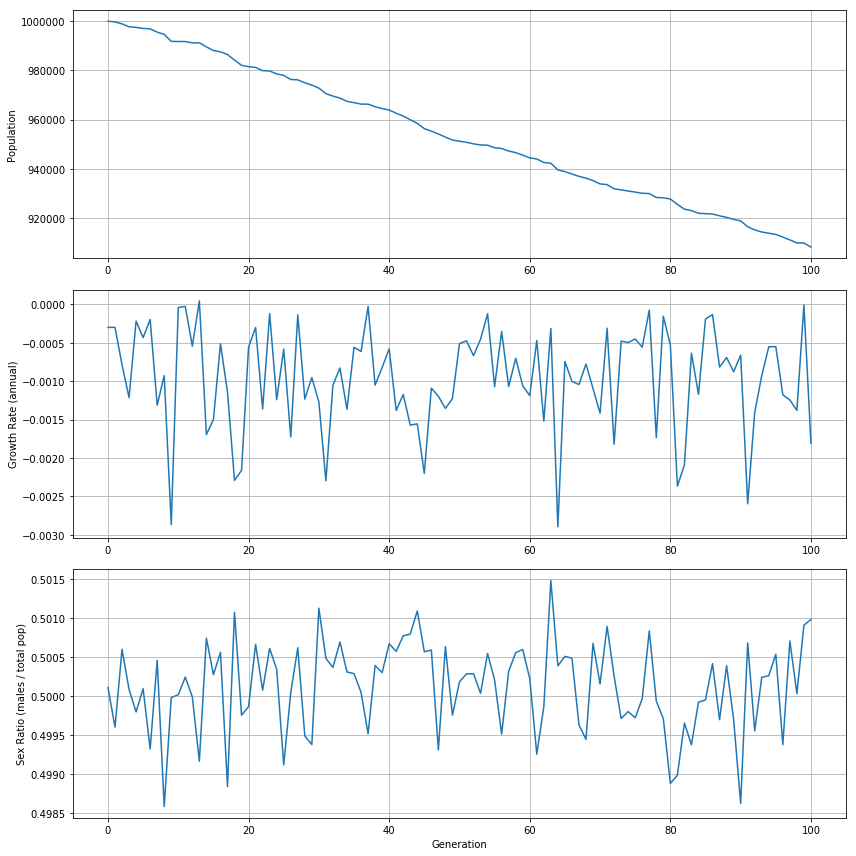

In [23]:
display_population_graphs(pop_stats)

In actual fact, we see that there is a slight but definite population decline, why is that?  As you can see,
although it is small, the growth rate for this set of parameters ended up being slightly negative.
This happens because even though we have set the sex_ratio to exactly 0.5, there will be some 
random fluctuation when we generate the MALE/FEMALE numbers in the population.
And since the number of couples is the minimum of the counts of these, the number of couples will always be slightly less than
1/2 of the population, thus each of these couples having 2 children is not quite enough to maintain a steady state
population size.

But of course, we can compensate for this by giving a bit higher of a fertility rate average per couple:

average population size: 1007957.534653
average growth rate: 0.000096
average sex ratio: 0.500087


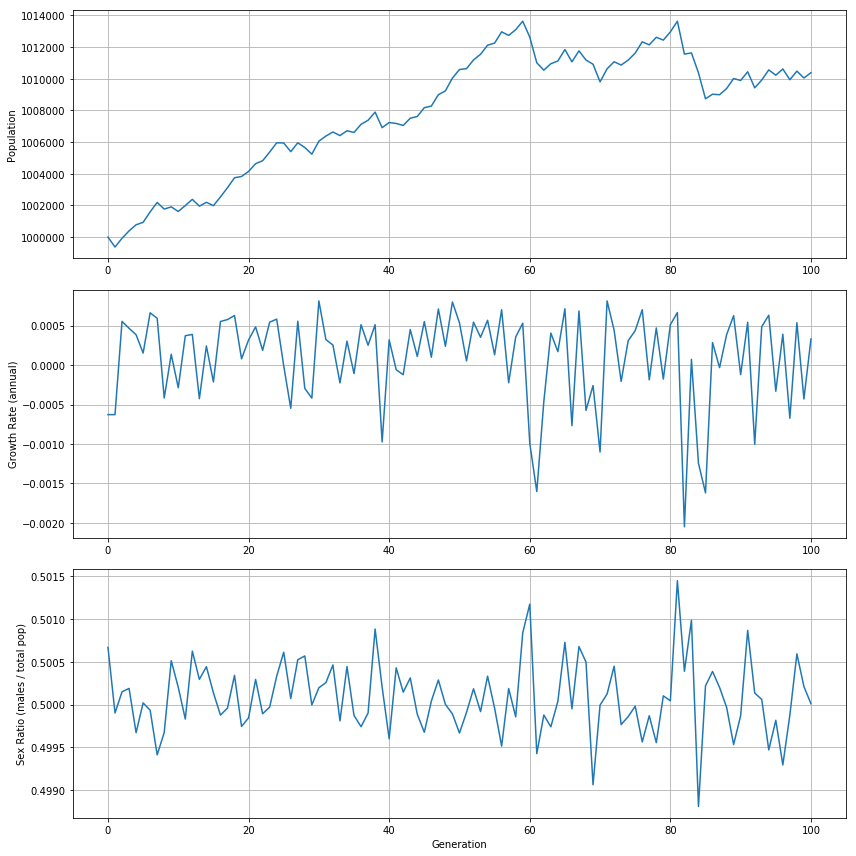

In [24]:
num_gens = 100
initial_population_size = int(1e6)
fertility_rate = (2.0015, 0.0001)
sex_ratio = 0.50

pop_stats = simulate_generations(num_gens, initial_population_size, fertility_rate, sex_ratio)
display_population_graphs(pop_stats)

Notice that only a very small bump above the replacement rate is needed to compensate for the random fluctuation 
in the sex ratio, just 1.5 thousandth of a percent in my empirical investigations.  Try the above simulations with only
a slightly higher or lower value, and see the greatly magnified result.  And by slight difference I do mean slight. 
I don't even mean 2.1 or 2.05, but much smaller.  The simulation we are working with here is an example of an 
exponential relationship.  Since each slight positive or negative percentage in the growth rate will be 
greatly magnified in its effect in the next generation. (And be careful, values like 2.1 will lead to 
populations in the billions, which can easily exhaust the memory of your machine and possibly cause crashes).

In natural human populations it is often seen that there is a slight bias towards the production of MALE
sexed children.  Often the natural ratio is something like 104 boys born for every 100 girls, or 
$ 104 / (100 + 104) \approx 0.5098 $.  Lets see what the previous simulation looks like with this slightly biased
sex ratio.

average population size: 177382.073090
average growth rate: -0.019089
average sex ratio: 0.509906


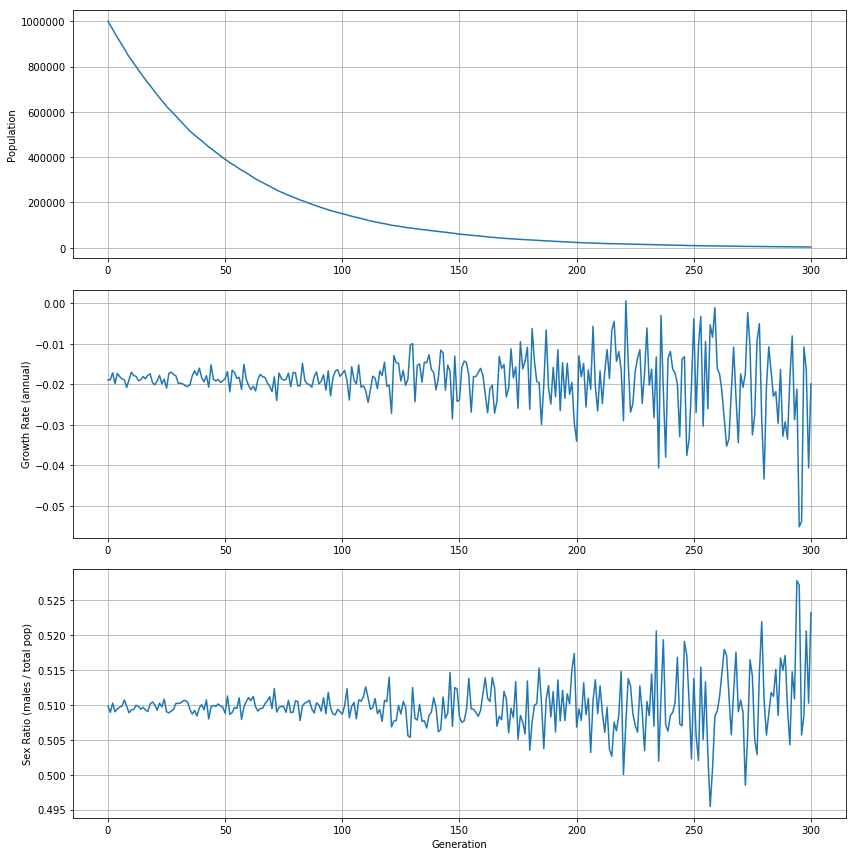

In [25]:
num_gens = 300
initial_population_size = int(1e6)
fertility_rate = (2.0015, 0.0001)
sex_ratio = 104./(100.+104.) # about 0.5098 ratio of boys in the child population

pop_stats = simulate_generations(num_gens, initial_population_size, fertility_rate, sex_ratio)
display_population_graphs(pop_stats)

This sex ratio actually leads to a -0.02 percent average growth rate (a decay) if we use the same fertility_rate that previously
achieved equilibrium.  With such a negative growth rate, the population will effectively die out after 300 generations.
To achieve equilibrium with this sex ratio, or for any given sex ratio, we will need a different fertility rate
value to offset the greater imbalance in the sex ratio:

average population size: 993212.108911
average growth rate: -0.000064
average sex ratio: 0.509824


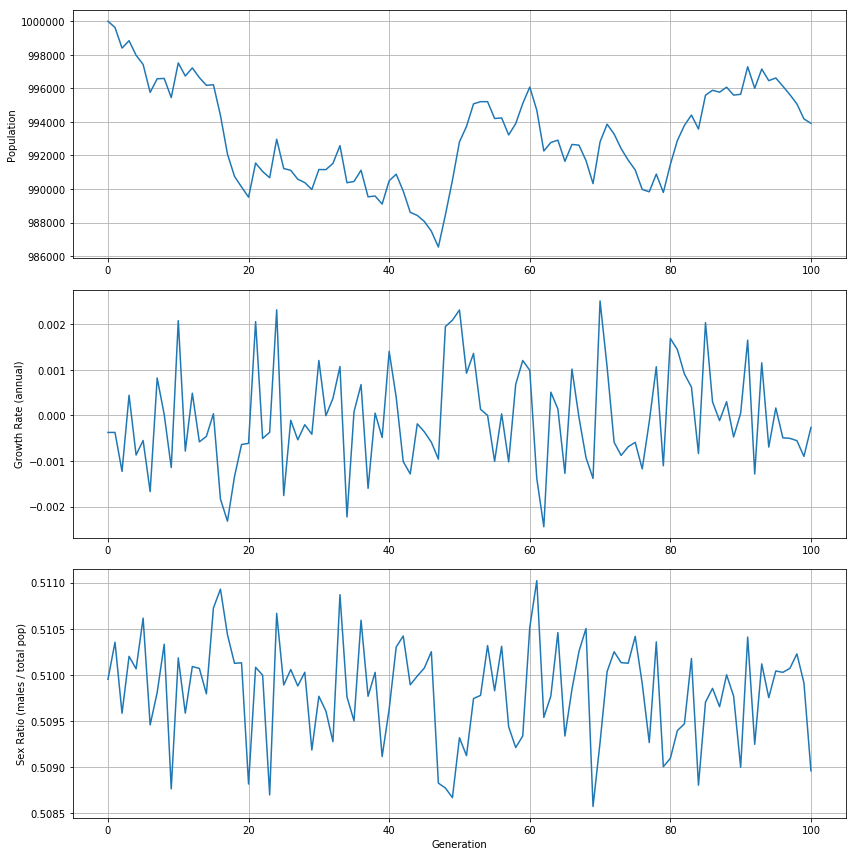

In [26]:
num_gens = 100
initial_population_size = int(1e6)
fertility_rate = (2.04, 0.0001)
sex_ratio = 104./(100.+104.) # about 0.5098 ratio of boys in the child population

pop_stats = simulate_generations(num_gens, initial_population_size, fertility_rate, sex_ratio)
display_population_graphs(pop_stats)

In the previous simulations we have used a very low standard deviation for the fertility rate, effectively 
having a constant fertility rate for each generation.  However, it would be more realistic if the fertility 
rate fluctuates with greater deviation.  Lets return to the previous example where we achieved 
equilibrium with the 104:100 sex ratio in the simulation, but see the effect of a 0.1 standard deviation 
in the fertility rates.

average population size: 2348064.267732
average growth rate: 0.001782
average sex ratio: 0.509791


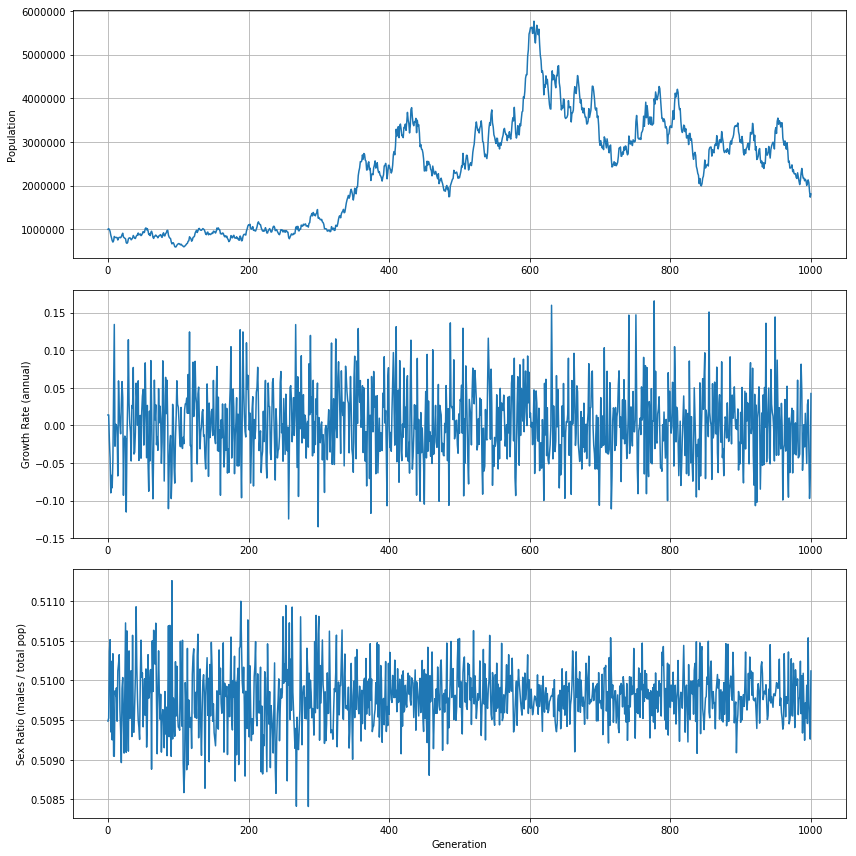

In [28]:
num_gens = 1000
initial_population_size = int(1e6)
fertility_rate = (2.041, 0.1)
sex_ratio = 104./(100.+104.) # about 0.5098 ratio of boys in the child population

pop_stats = simulate_generations(num_gens, initial_population_size, fertility_rate, sex_ratio)
display_population_graphs(pop_stats)

If you run the previous simulation settings several time, you may be surprised to see that the simulation can sometimes 
randomly walk pretty close to an extinction event, with population dwindling to 0.  This didn't happen for 
me in my empirical investigations, but I saw populations as low as 200,000.  This illustrates that this is
indeed a random simulation.  The standard deviation we use, assuming we have achieved a stable
generational growth rate of 0.0, causes a random walk to be performed around the starting population
size of 1 million individuals.  But larger standard deviations in the fertility rate can lead to even larger
random deviations from the initial starting value.

Lets think a little bit about actual policies aimed at controlling population size and birth rates.  For example, 
lets imagine a perfect implementation and enforcement of China's one child policy.  If you have understood the
previous simulations, I'm sure you will realize that having only 1 child per couple per generation will lead
to much lower fertility than the rates needed for replacement of the population.

average population size: 178290.818182
average growth rate: -0.508801
average sex ratio: 0.508161


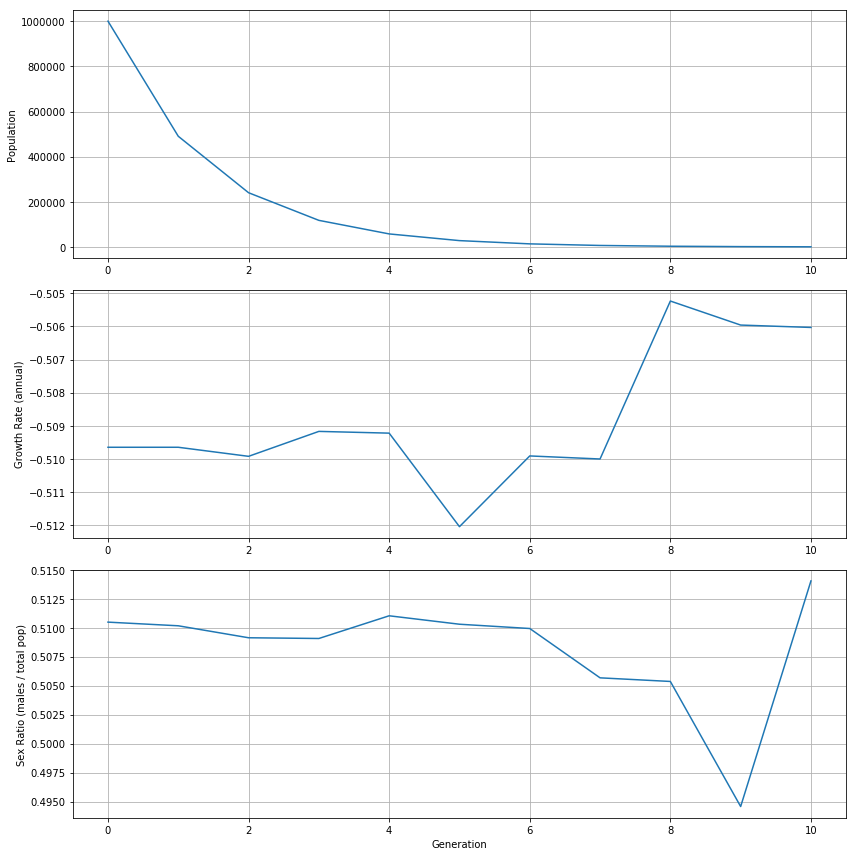

In [29]:
num_gens = 10
initial_population_size = int(1e6)
fertility_rate = (1.0, 0.001)
sex_ratio = 104./(100.+104.) # about 0.5098 ratio of boys in the child population

pop_stats = simulate_generations(num_gens, initial_population_size, fertility_rate, sex_ratio)
display_population_graphs(pop_stats)

And in fact, since the population size is effecively halved each generation, we end up with 0 population size from 
a starting size of 1 million within about 10 generations. Because this is an exponential function, it would
only take twice as many generations, about 20, to reduce a population of 1 billion individuals to 0.

The actual current fertility rate of China is estimated to be at an amazingly low rate of 1.58 births per woman
in 2013 [Google Public Data from WorldBank](https://www.google.com/publicdata/explore?ds=d5bncppjof8f9_&ctype=l&strail=false&bcs=d&nselm=h&met_y=sp_dyn_tfrt_in&scale_y=lin&ind_y=false&rdim=region&idim=country:CHN:IND:USA&ifdim=region&hl=en&dl=en&ind=false).  But the estimated imbalance in the sex ratio at birth in
China has reached the worrying level of 112:100 males born to females (0.528 ratio) 
[CIA World Fact Book](https://www.cia.gov/library/publications/the-world-factbook/fields/2018.html)

Given these two parameters, and a current population of about 1.4 billion people in China, lets see what
the expected population size would look like if these two factors were to hold for some number of
generations.  Creating an array of 1.4 billion simulated individuals may be a bit much for most
systems, so we will use 1.4 million individuals.

average population size: 143984.780488
average growth rate: -0.283238
average sex ratio: 0.529011


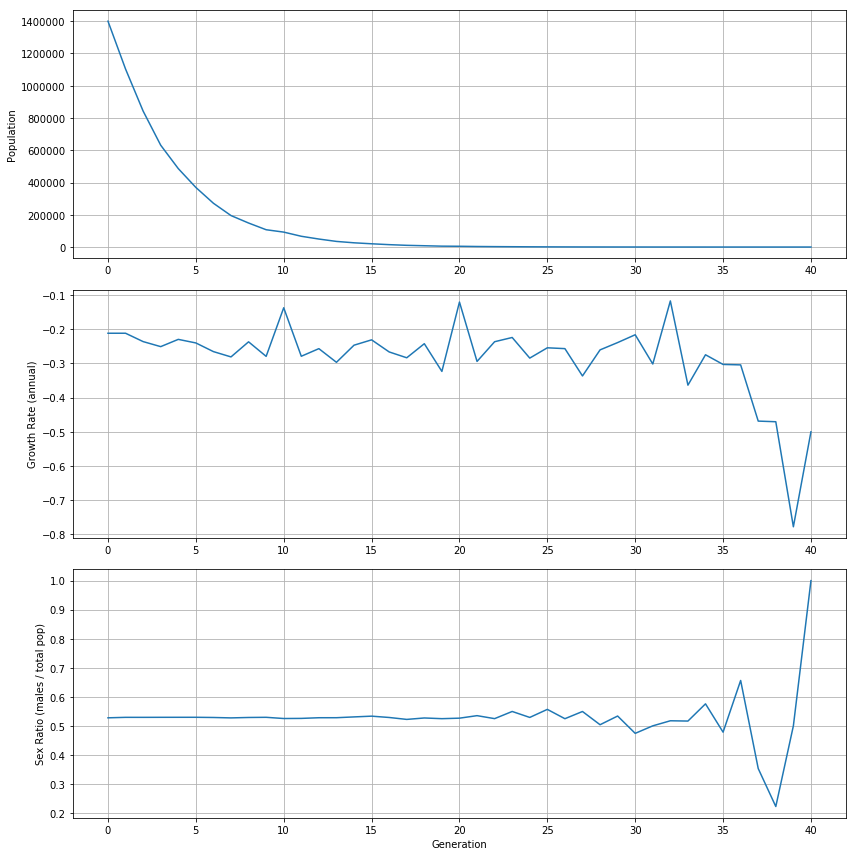

In [30]:
num_gens = 40
initial_population_size = int(1.4e6)
fertility_rate = (1.58, 0.1)
sex_ratio = 112./(100.+112.) # about 0.5283 ratio of boys in the child population

pop_stats = simulate_generations(num_gens, initial_population_size, fertility_rate, sex_ratio)
display_population_graphs(pop_stats)

I usually see the population reduced to 0 by about generation 37, and almost always by generation 40.
Although the previous simulation uses a population of 1.4 million rather than 1.4 billion, it still gives the same
answer to questions such as, how long would it take to halve the population (about 2.12 generations).  The important
number is the growth rate, or in this case the decay rate, which empirically we obtain something like -0.278.  Of course
a human generation is something like 25 years, so this means, if the current fertility rate were to be sustained,
we would begin to see a reduction in population that would lead to half the population size in China in
50 or so years.

In [31]:
%reload_ext version_information

%version_information numpy, scipy, matplotlib

Software versions
Python 2.7.13 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 5.3.0
OS Linux 4.13.0 32 generic x86_64 with debian stretch sid
numpy 1.13.1
scipy 0.19.1
matplotlib 2.0.2
Mon Feb 19 11:57:57 2018 CST